In [1]:
# Imports
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch as torch
from torch import nn
from nltk.tokenize import word_tokenize
import math as mt
import time
import random
from joblib import Parallel, delayed
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import shuffle
import helper
print("Done")

Done


## Load model

In [25]:
if torch.cuda.is_available():
    device = "cpu"#"cuda:0"
else:
    device = "cpu"
    
url = 'https://raw.githubusercontent.com/salmanedhi/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv'

data = pd.read_csv(url, sep='\t')
    
#data = pd.read_csv('data/hindi_hatespeech.tsv', sep='\t')
data_development = shuffle(data)
labels = data_development['task_2']
# data_development = data
type(data_development['task_1'])

print("Done", device)

Done cpu


In [21]:
#Stopwords Removal
sentences = helper.apply_stopword_removal(data_development)
print("Number of sentences: " , len(sentences))

#Building Vocabulary
V, non_unique = helper.build_vocabulary(sentences)
print('Total words:', len(non_unique))
print('Unique words:', len(V))

Number of sentences:  4665
Total words: 141550
Unique words: 19836


In [4]:
#Load Word2Vec embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_finalised', device, len(V), 600)
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=19836, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=19836, bias=True)
)
torch.Size([19837, 600]) torch.Size([600, 19836])


## Create Dataset

In [26]:
## create number array of sentences (replace each word with each numeric value)
x_data, max_len_curr = helper.sentence_to_numeric_arr(sentences, V)

## apply padding
padded = np.array(helper.padding(x_data, max_len_curr))

print(padded.shape)
encoded_labels = [0 if label == "NONE" else 1 for label in labels]
encoded_labels = np.array(encoded_labels)
print(encoded_labels.shape)

(4665, 132)
(4665,)


In [27]:
#split data into train, valid & test set
batch_size = 64
train_loader, valid_loader, test_loader = helper.split_data_train_valid_test(padded, encoded_labels, batch_size)
print("Done")

Done


In [7]:
net, criterion, optimizer = helper.initialize_SentimentLSTM_model(len(V) + 1, 600, 32, 1, 2, device, weights1)

print(net)

SentimentLSTM(
  (embedding): Embedding(19837, 600)
  (lstm): LSTM(600, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
print_every = 100
step = 0
n_epochs = 100  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# if torch.cuda.is_available():
#     device = "cuda:0"
# else:
#     device = "cpu"
# print(device)

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
#         print(i, inputs.shape, labels.shape)
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if (step % print_every) == 0:            
            ######################
            ##### VALIDATION #####
            ######################
            net.eval()
            valid_losses = []
            v_h = net.init_hidden(batch_size)
            
            for v_inputs, v_labels in valid_loader:
                v_inputs, v_labels = inputs.to(device), labels.to(device)
        
                v_h = tuple([each.data for each in v_h])
                
                v_output, v_h = net(v_inputs, batch_size)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())

            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
            net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
    
print("Done")

<ipython-input-8-8594e4f0caa4>:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


KeyboardInterrupt: 

0


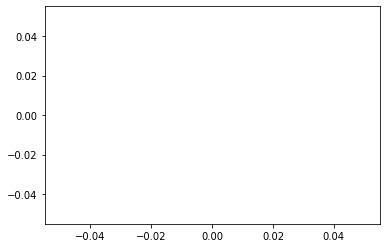

In [9]:
print(len(training_loss_epoches))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
torch.save(net, 'model_task2')
torch.save(net.state_dict(), 'model_param_task2')

In [ ]:
net.load_state_dict(torch.load('model_param_task2_final')) #GPU

# net.load_state_dict(torch.load('model_param_task2_final',map_location=torch.device('cpu'))) #for salman CPU only
net.to(device)

## Test set

In [10]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 0.6918
Test Accuracy: 0.51


In [11]:
print(len(test_y) - np.sum(test_y))
print(np.sum(test_y))
print(len(encoded_labels))
print(np.sum(encoded_labels))

NameError: name 'test_y' is not defined

## Testing Bengali Data on Hindi Classifier

In [34]:
#Reading Bengali data
bengali_data, labels = helper.get_bengali_data('data/bengali_hatespeech.csv')
# print(bengali_data)
print(bengali_data.shape, labels.shape)

(4665, 3) (4665,)


In [35]:
## Stopwords Removal of Bengali Data
bengali_sentences = helper.apply_stopword_removal(bengali_data)
print("Number of sentences: " , len(bengali_sentences))

## Building Vocabulary
bengali_V, bengali_non_unique = helper.build_vocabulary(bengali_sentences)
print('Total words:', len(bengali_non_unique))
print('Unique words:', len(bengali_V))

## Sentence to numeric array
x_data_bengali, max_len_curr = helper.sentence_to_numeric_arr(bengali_sentences, bengali_V)

## Apply Padding
padded = np.array(helper.padding(x_data_bengali, max_len_curr))

Number of sentences:  4665
Total words: 64027
Unique words: 14482


In [14]:
#create test data to pass to the model
test_data = TensorDataset(torch.tensor(padded), torch.tensor(labels))
batch_size = 64
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True, drop_last=True)

In [15]:
net.eval()

test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 0.6932
Test Accuracy: 0.49


## Training classifier on Bengali embeddings

In [36]:
#Load Word2Vec embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_finalised_bengali', device, len(bengali_V), 600)
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=14482, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=14482, bias=True)
)
torch.Size([14483, 600]) torch.Size([600, 14482])


In [37]:
#split data into train, valid & test set
train_loader, valid_loader, test_loader = helper.split_data_train_valid_test(padded, labels, 64)

print("Done")

Done


In [38]:
net, criterion, optimizer = helper.initialize_SentimentLSTM_model(len(bengali_V) + 1, 600, 32, 1, 2, device, weights1)

print(net)

SentimentLSTM(
  (embedding): Embedding(14483, 600)
  (lstm): LSTM(600, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
